In [2]:
from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding
import torch

/home/wzw/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
d = 128
max_position_embeddings = 4096
rope_theta = 10000

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(x, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed

class RecursiveNamespace:
    def __init__(self):
        self.__dict__['_attributes'] = {}

    def __getattr__(self, name):
        if name not in self._attributes:
            self._attributes[name] = RecursiveNamespace()
        return self._attributes[name]

    def __setattr__(self, name, value):
        if isinstance(value, RecursiveNamespace):
            self._attributes[name] = value
        else:
            current = self
            *parts, last = name.split('.')
            for part in parts:
                current = getattr(current, part)
            current._attributes[last] = value

    def __repr__(self):
        return repr(self._attributes)

In [9]:
rotary_emb = LlamaRotaryEmbedding(
    d,
    max_position_embeddings,
    rope_theta,
)

A = RecursiveNamespace()
A.device.type = 'cpu'
A.dtype = torch.float32

position_ids = torch.arange(max_position_embeddings).view(1, max_position_embeddings)
cos, sin = rotary_emb(A, position_ids)

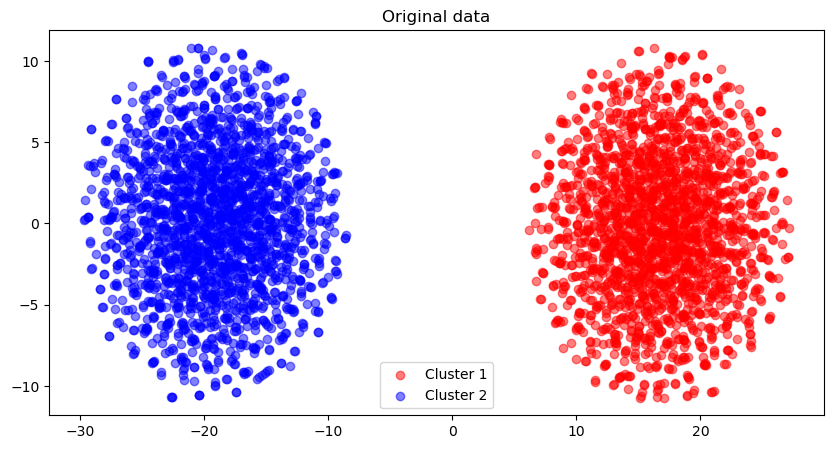

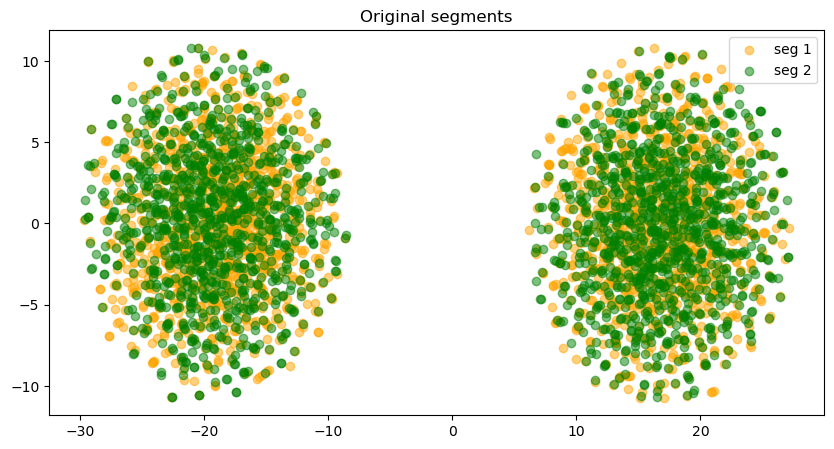

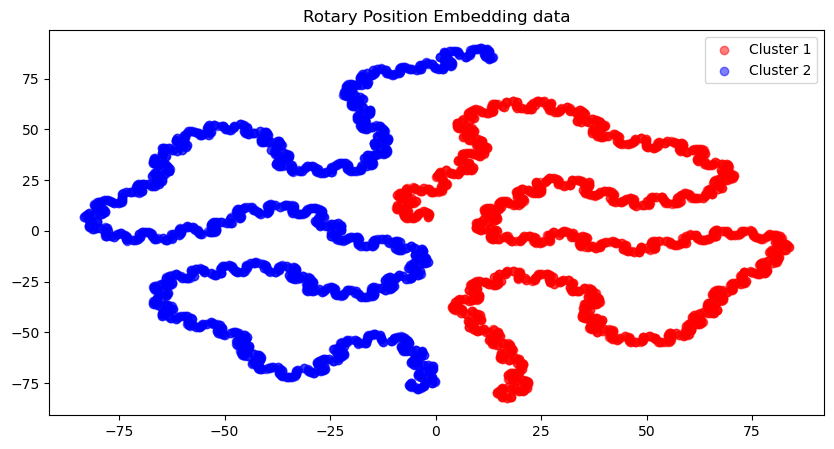

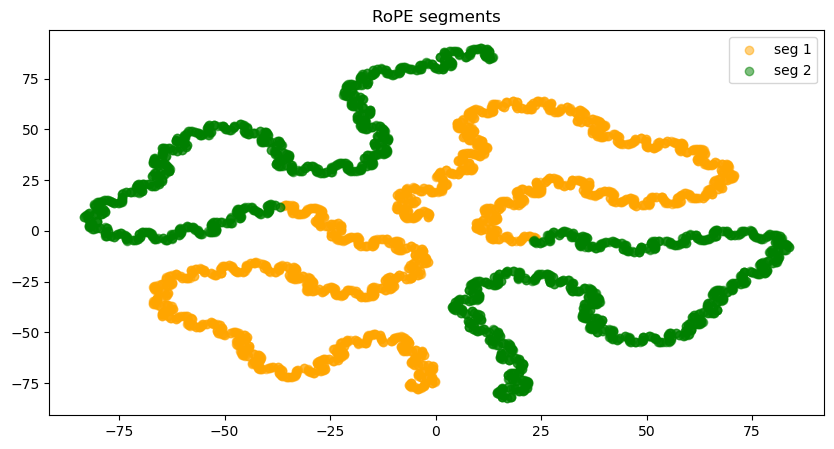

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


n1 = max_position_embeddings // 2
n2 = max_position_embeddings // 2

# 生成两个具有不同均值的正态分布数据簇
X1 = torch.randn((n1, d)) + 5  # 第一个簇，均值为5
X2 = torch.randn((n2, d)) - 5  # 第二个簇，均值为-5

# 合并两个簇
X = torch.cat((X1, X2), dim=0)

# 创建标签
labels = torch.cat((torch.zeros(n1), torch.ones(n2)))

# shuffle X and labels
indices = torch.randperm(X.size(0))
X = X[indices]
labels = labels[indices]

# apply rotary position embedding
X_embed = apply_rotary_pos_emb(X, cos, sin, position_ids=position_ids, unsqueeze_dim=1).view(-1, d)


# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

X_embed_tsne = tsne.fit_transform(X_embed)

# 可视化 Original data
plt.figure(figsize=(10, 5))

# 使用不同颜色标注不同簇
plt.scatter(X_tsne[labels == 0, 0], X_tsne[labels == 0, 1], c='red', label='Cluster 1', alpha=0.5)
plt.scatter(X_tsne[labels == 1, 0], X_tsne[labels == 1, 1], c='blue', label='Cluster 2', alpha=0.5)

plt.legend()
plt.title('Original data')
plt.show()

# 可视化 Original segements
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:max_position_embeddings//2, 0], X_tsne[:max_position_embeddings//2, 1], c='orange', alpha=0.5, label='seg 1')
plt.scatter(X_tsne[max_position_embeddings//2:, 0], X_tsne[max_position_embeddings//2:, 1], c='green', alpha=0.5, label='seg 2')
plt.legend()
plt.title('Original segments')
plt.show()


# 可视化 Rotary Position Embedding data
plt.figure(figsize=(10, 5))

# 使用不同颜色标注不同簇
plt.scatter(X_embed_tsne[labels == 0, 0], X_embed_tsne[labels == 0, 1], c='red', label='Cluster 1', alpha=0.5)
plt.scatter(X_embed_tsne[labels == 1, 0], X_embed_tsne[labels == 1, 1], c='blue', label='Cluster 2', alpha=0.5)

plt.legend()
plt.title('Rotary Position Embedding data')
plt.show()

# 可视化 RoPE segements
plt.figure(figsize=(10, 5))
plt.scatter(X_embed_tsne[:max_position_embeddings//2, 0], X_embed_tsne[:max_position_embeddings//2, 1], c='orange', alpha=0.5, label='seg 1')
plt.scatter(X_embed_tsne[max_position_embeddings//2:, 0], X_embed_tsne[max_position_embeddings//2:, 1], c='green', alpha=0.5, label='seg 2')
plt.legend()
plt.title('RoPE segments')
plt.show()





